# Self-organizing map

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import susi
from susi.SOMPlots import plot_nbh_dist_weight_matrix, plot_umatrix
import xarray as xr

### Import the raster data and transform to dataframe:

In [2]:
vars_vec = np.array(['HCP1QP', 'PRP1QP', 'HCP2QP', 'PRP2QP', 'HCP4QP', 'PRP4QP'], dtype=np.dtype(object))
raster_files = list("Interpolations/IDW_10" + vars_vec + ".tiff")

stack_xr = xr.open_rasterio(raster_files[0])
stack_xr = stack_xr.assign_coords(band=("band", [vars_vec[0]]))
stack_xr = stack_xr.where(stack_xr != -999.)
stack_data = stack_xr.to_dataset(dim="band")

i=1
for file in raster_files[1:12]:
    layer = xr.open_rasterio(file)
    layer = layer.where(layer != -999.)
    layer_data = layer.to_dataset(dim="band")
    stack_data[str(vars_vec[i])]= layer.squeeze()
    i += 1
    
df_raster = stack_data.to_dataframe()[vars_vec] 
rows_with_nan = df_raster.isnull().any(axis=1)
df_nona = df_raster[~rows_with_nan]
SOM_dat = np.array(df_nona)

## SOM implemented using miniSOM

The SOM approach makes use of the concept of vector quantization that is also behind the k-means algorithm. This means that the result of the algorithm will be a set of model vectors, and each observation is mapped to one of these model vectors based on a similarity measure. In k-means each model vector was then the center of the cluster. The Self-Organizing Map is different from the classical vector quantization in two aspects: firstly the number of model vectors is larger than the desired number of clusters, secondly the different model vectors are not updated independently but are related through a neighbourhood function ([Kohonen, 2013](https://www.sciencedirect.com/science/article/pii/S0893608012002596); [Riese et al., 2019](https://www.mdpi.com/2072-4292/12/1/7)). Therefore they are usually referred to as ‘nodes’ and can be visualized on a 2D grid. Every observation is thus mapped onto one of these nodes, observations that are mapped to the same node or nearby nodes have similar feature vectors ([Klose, 2006](https://doi.org/10.1007/s10596-006-9022-x)).

Hyperparameters that have to be determined by the user are:
* The size of the SOM grid, a rule of thumb is to have $5*\sqrt{N\_observations}$ as the number of nodes [(Karmakar et al., 2018)](http://link.springer.com/10.1007/s11001-017-9327-2).
* The type of the neighborhood function
* Initial parameters (learning rate, parameters of the neighborhood function)
* Decay of the initial parameters
* Number of iterations


The miniSOM library is used to fit a SOM on the EMI data [(Vettigli, 2018)](https://github.com/JustGlowing/minisom/).

In [3]:
from minisom import MiniSom
from sklearn import preprocessing as prep
df_std = pd.DataFrame(prep.StandardScaler().fit_transform(df_nona)) # Since SOM uses distance between points, but maybe better to rescale to [0,1]
df_std.columns = vars_vec
SOM_std = np.array(df_std)

In [4]:
gridrows = 25
gridcols = 25
s = 5

som = MiniSom(gridrows,gridcols, 6, learning_rate=0.5, sigma = s, neighborhood_function='gaussian')
# 25x25 grid (rule of thumb to have 5*sqrt(N) nodes, from miniSOM documentation + Karmakar 2017)
# 12 variables
# learning_rate = initial learning rate; at t: learning_rate(t) = learning_rate / (1 + 2t/T)
# sigma = spread of initial neighborhood function; at t: sigma(t) = sigma / (1 + 2t/T)
# gaussian neighborhood function h = exp(-d²/(2*sigma²(t)))
# (It is possible to define other decay functions)
# Use quantization error to optimize hyperparameters?

som.train(SOM_std, 100000)

The nodes of the SOM are initialized with random weights, which are 6-dimensional vectors in feature space since we have 6 variables. Then the SOM grid is updated iteratively in order to approximate the distribution of the data. Each iteration consists of the following steps ([Klose, 2006](https://doi.org/10.1007/s10596-006-9022-x)):

1. For a random observation, the nearest grid node is determined. That is the node whose weight is the closest, determined by the Euclidean distance, to the vector of the selected observation. This node is often referred to as the best matching unit or winner.

2. The weights of the winner are updated to minimize its distance to the observation. Besides also nodes that are in the neighborhood of the observations but are not the best-matching unit are updated. The update rule for the weights of any node k is defined as:\
$\vec{w_k}(t+1) = \vec{w_k}(t) + \eta(t)*h_{k,j(x)}(t)*(\vec{x_i}(t) - \vec{w_k}(t))$.

**Learning rate and neighborhood function**\
In the update rule, $\eta(t)$ is the learning rate that is a function of t, it decays throughout the iteration process. In miniSOM, the learning rate at each step is calculated as $\eta(t) = \eta(1)/(1+\frac{2t}{t_{max}})$.

$h_{k,j(x)}(t)$ is the neighborhood function around the winner. It decreases with increasing distance from the winner and also becomes more narrow throughout the iteration process. MiniSOM uses a pseudo-gaussian neighborhood function, which means that at step t, the neighborhood function is: $h_{k,j(x)}(t) = exp(\frac{-d^2_{k,j(\vec{x})}}{2*\sigma^2})$.\
At each iteration, the neigborhood function becomes more narrow because $\sigma$ is also a function of the iteration step. Similarly to the learning rate, sigma decays by $\sigma(t) = \sigma(1)/(1+\frac{2t}{t_{max}})$.

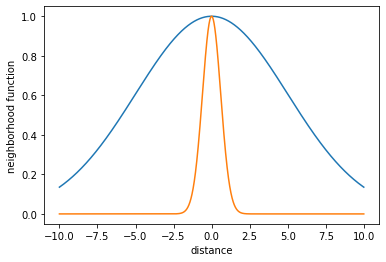

In [5]:
# Visualize neighborhood function

# at start:
sigma_start = s
dist = np.linspace(-10, 10, 10000)
neigh = np.exp(-np.power(dist,2)/(2*sigma_start**2))
plt.plot(dist, neigh)

# at end:
n_iter = 100000
sigma_end = sigma_start / 3
neigh = np.exp(-np.power(dist,2)/ 2*sigma_end**2)
plt.plot(dist, neigh)
plt.xlabel('distance')
plt.ylabel('neighborhood function')
plt.show()

The neighborhood function should be wide enough at the start so that the grid is spread over the entire data space. At the end of the algorithm it should become narrow enough to finetune the weights of the nodes to smaller variations in the data ([Kohonen, 2013](https://www.sciencedirect.com/science/article/pii/S0893608012002596)). To check whether the used parametrization for the neighborhood function is appropriate, it should be compared with the dimensions of the data in feature space.

In [6]:
# Check with data whether these distances are relevant! 
#from scipy.spatial import distance_matrix
#dist = distance_matrix(df_std,df_std)
#pd.DataFrame(dist.flatten()).describe() # largest distance between points = 15, average 2.9, std =1.89

The result of the SOM algorithm can then be assessed by making use of a distance map. The map visualizes the information in the SOM grid by displaying the sum of the distances to the adjacent nodes, normalized to obtain values between 0 and 1.

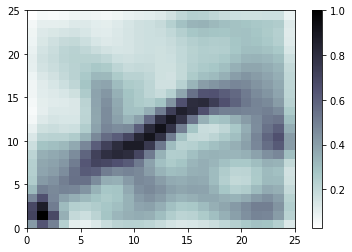

In [7]:
plt.pcolor(som.distance_map(), cmap='bone_r')
plt.colorbar()
plt.show()

The distance map shows that there are areas in feature space with a higher data density than others. Most clearly, there is a clear separation between two groups.

### Plot variables on the SOM grid

To have a better understanding of the structure of the data, the values of the variables can be plotted on the SOM grid. Each node on the grid is associated with a subset of observations that have this node as their 'best matching unit' or 'winner'. For each node, we can calculate the average values of the variables of its associated observations and visualize these averages on the same 25x25 grid. This allows to see the trends in the data and how the variables relate to each other.

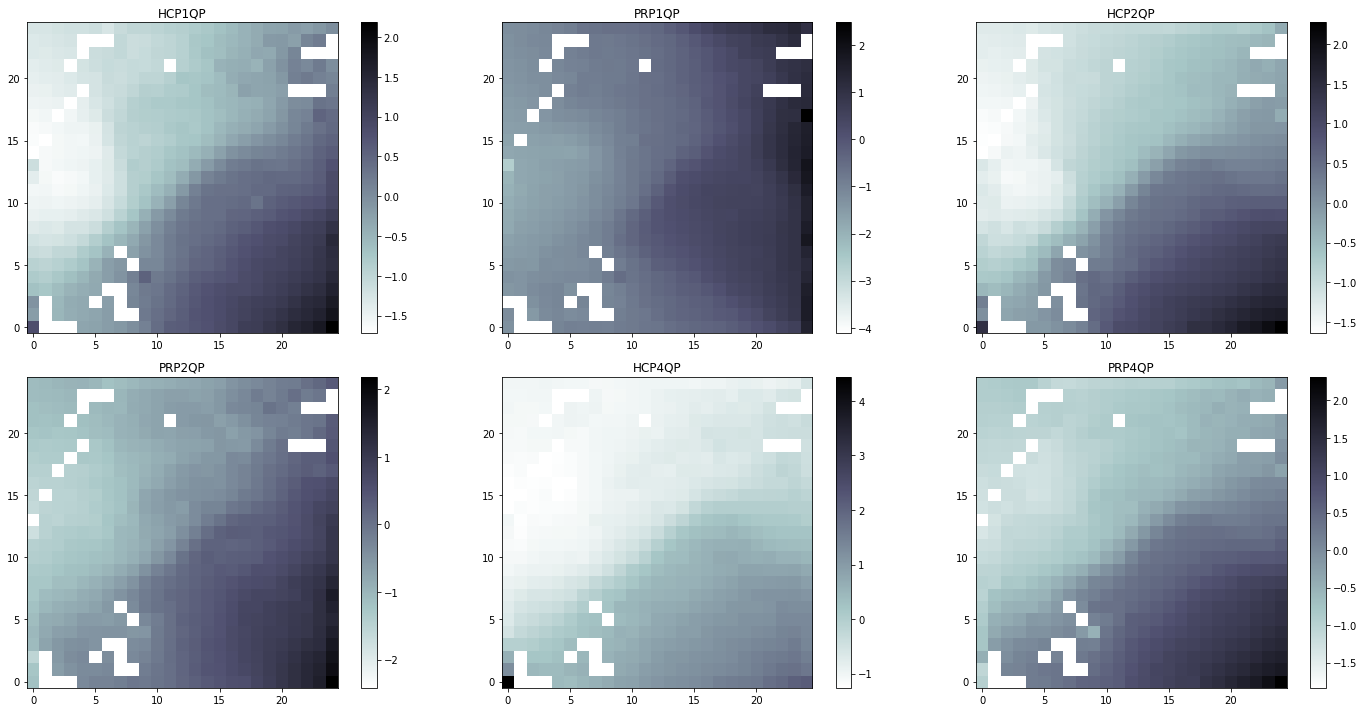

In [8]:
winners = []

for k in range(SOM_std.shape[0]):
    winners.append(som.winner(SOM_std[k]))  #Stores the grid coord of the winner for each observation as a tuple

    
grid_coded = np.array(range(625)).reshape(25,25)    # For practical reasons, number the nodes on the grid from 0 to 624
df_codes = pd.DataFrame(grid_coded.reshape(625,))

df_std['winner code'] = np.array([grid_coded[i] for i in winners]) #With each raster value we associate the code of its winner
grouped = df_std.groupby('winner code')
SOMa = grouped.mean() # Calculate the avg value of observations with same 'winner' node.
SOM_avgs = pd.concat([SOMa, df_codes], axis=1)
cols = np.concatenate([vars_vec, np.array(['winner code'])])
SOM_avgs.columns = cols

i = 0
avgs_grid = np.empty((25,25,6))
for var in vars_vec:
    avgs_grid[:,:,i] = np.array(SOM_avgs[var]).reshape(25,25)   # Transform the columns of avgs to a 25x25 grid
    i += 1

fig = plt.figure(figsize=(20,10))
    
for i in range(1,7):
    ax = fig.add_subplot(2,3,i)
    ax.set_title(vars_vec[i-1])
    pc = ax.imshow(avgs_grid[:,:,i-1], cmap='bone_r', origin='lower')
    fig.colorbar(pc, ax=ax, orientation='vertical')

plt.tight_layout()
plt.show()

This analysis again points out that the 6 variables are strongly correlated since all plots look roughly the same. 

## Use the SOM grid to obtain a classification of the data

K-means can be performed on the weights of the SOM grid, which can then be used to classify the original data [(Filippi et al., 2010)](https://www.intechopen.com/books/self-organizing-maps/self-organizing-map-based-applications-in-remote-sensing)


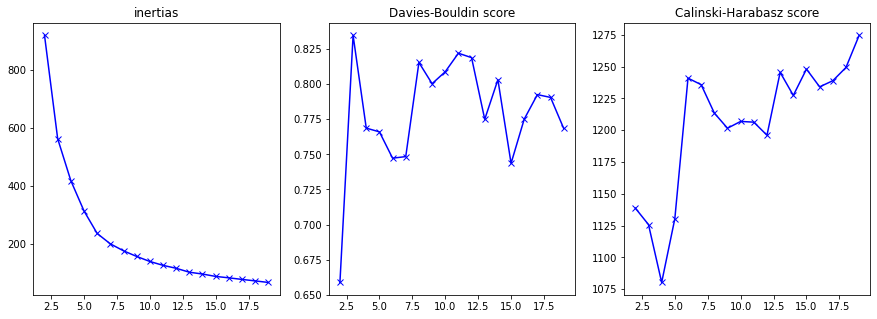

In [15]:
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score
neurons = som.get_weights().reshape(gridrows*gridcols,6)
K = range(2,20)
inertias = []
DB_score = []
CH_score = []

for k in K:
    clusterSOM = KMeans(n_clusters=k, random_state=0, n_init=5, init='k-means++').fit(neurons)
    inertias.append(clusterSOM.inertia_)
    labs = clusterSOM.labels_
    DB_score.append(davies_bouldin_score(neurons, labs))
    CH_score.append(calinski_harabasz_score(neurons, labs))

fig, (ax0, ax1, ax2) = plt.subplots(1,3, figsize=(15,5))
ax0.plot(K, inertias, 'bx-')
ax0.set_title('inertias')
ax1.plot(K, DB_score, 'bx-')
ax1.set_title('Davies-Bouldin score')
ax2.plot(K, CH_score, 'bx-')
ax2.set_title('Calinski-Harabasz score')
plt.show()

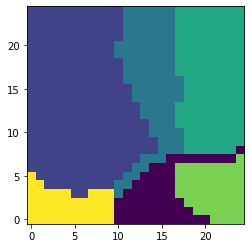

In [30]:
clusterSOM = KMeans(n_clusters=6, random_state=0, n_init=5, init='k-means++').fit(neurons)
clusters = clusterSOM.predict(neurons).reshape(gridrows,gridcols)
plt.imshow(clusters, origin='lower')
plt.show()

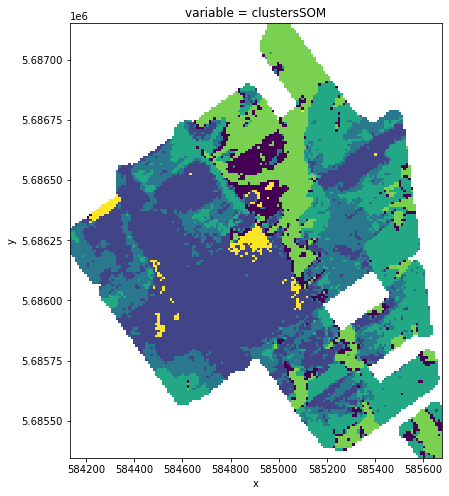

In [31]:
SOM_bmus = np.array(winners)

raster_clusters = np.empty((27540))
raster_clusters[:] = np.nan
raster_clusters[~rows_with_nan] = np.array([clusters[i] for i in winners])


df_raster['clustersSOM'] = raster_clusters 

xr_clusters = df_raster.to_xarray().transpose('y', 'x')

cl_array = xr_clusters.to_array()
ax = cl_array.sel(variable='clustersSOM').plot.pcolormesh(figsize=(8,8), add_colorbar=False)
ax.axes.set_aspect('equal')

## Calculate the DB-score

This allows to compare the classification with that of K-means

In [18]:
from sklearn.metrics import davies_bouldin_score

davies_bouldin_score(SOM_std, raster_clusters[~rows_with_nan])

1.109717586501706

K-means with 5 clusters has a much higher DB-score!
But the 'optimal' K-means has a lower DB-score

## SOM with coordinates as attributes

In [38]:
df_raster = stack_data.to_dataframe()[vars_vec]
df_xy = df_raster.reset_index()
rows_with_nan = df_xy.isnull().any(axis=1)
df_nona = df_xy[~rows_with_nan]
df_stdxy = pd.DataFrame(prep.StandardScaler().fit_transform(df_nona))
SOM_stdxy = np.array(df_stdxy)

In [27]:
gridrows = 25
gridcols = 25
s = 5

somxy = MiniSom(gridrows,gridcols, 8, learning_rate=0.5, sigma = s, neighborhood_function='gaussian')
# 25x25 grid (rule of thumb to have 5*sqrt(N) nodes, from miniSOM documentation + Karmakar 2017)
# 12 variables
# learning_rate = initial learning rate; at t: learning_rate(t) = learning_rate / (1 + 2t/T)
# sigma = spread of initial neighborhood function; at t: sigma(t) = sigma / (1 + 2t/T)
# gaussian neighborhood function h = exp(-d²/(2*sigma²(t)))
# (It is possible to define other decay functions)
# Use quantization error to optimize hyperparameters?

somxy.train(SOM_stdxy, 100000)

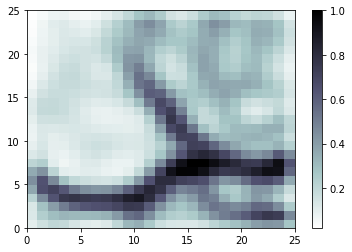

In [28]:
plt.pcolor(somxy.distance_map(), cmap='bone_r')
plt.colorbar()
plt.show()

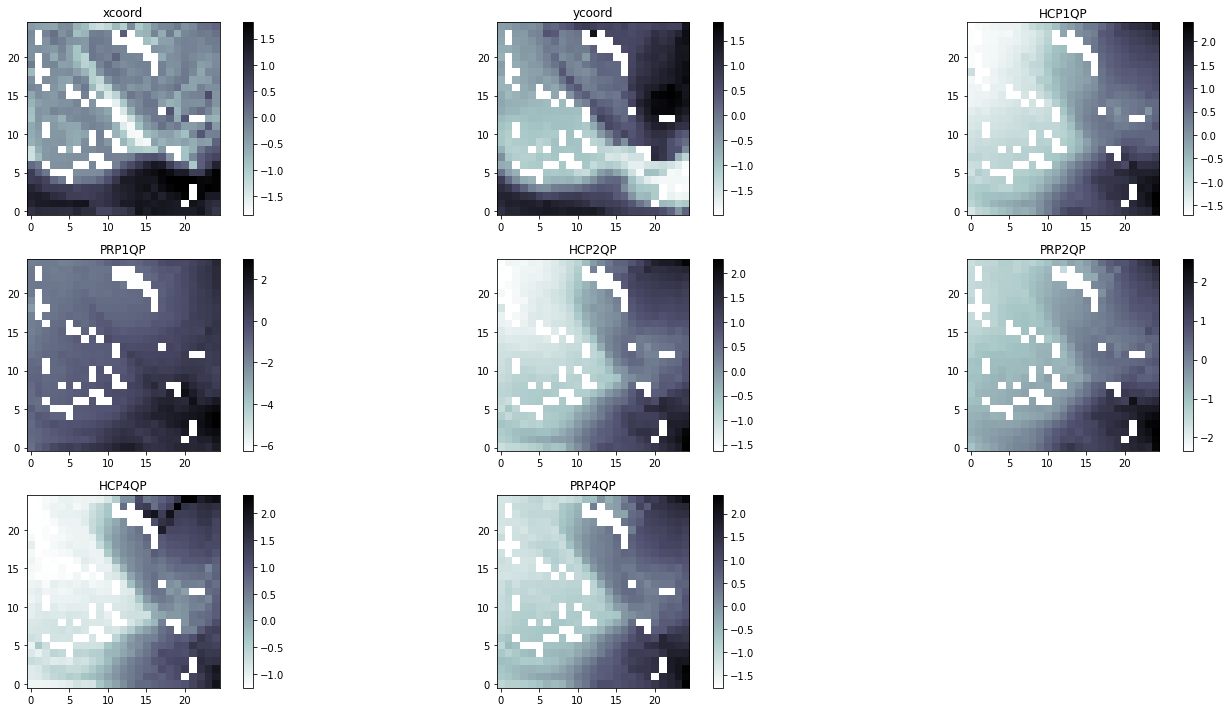

In [42]:
winners = []

for k in range(SOM_stdxy.shape[0]):
    winners.append(somxy.winner(SOM_stdxy[k]))  #Stores the grid coord of the winner for each observation as a tuple

    
grid_coded = np.array(range(625)).reshape(25,25)    # For practical reasons, number the nodes on the grid from 0 to 624
df_codes = pd.DataFrame(grid_coded.reshape(625,))

df_stdxy['winner code'] = np.array([grid_coded[i] for i in winners]) #With each raster value we associate the code of its winner
grouped = df_stdxy.groupby('winner code')
SOMa = grouped.mean() # Calculate the avg value of observations with same 'winner' node.
SOM_avgs = pd.concat([SOMa, df_codes], axis=1)
xyvars_vec = np.array(['xcoord', 'ycoord', 'HCP1QP', 'PRP1QP', 'HCP2QP', 'PRP2QP', 'HCP4QP', 'PRP4QP'], dtype=np.dtype(object))
cols = np.concatenate([xyvars_vec, np.array(['winner code'])])
SOM_avgs.columns = cols

i = 0
avgs_grid = np.empty((25,25,8))
for var in xyvars_vec:
    avgs_grid[:,:,i] = np.array(SOM_avgs[var]).reshape(25,25)   # Transform the columns of avgs to a 25x25 grid
    i += 1

fig = plt.figure(figsize=(20,10))
    
for i in range(1,9):
    ax = fig.add_subplot(3,3,i)
    ax.set_title(xyvars_vec[i-1])
    pc = ax.imshow(avgs_grid[:,:,i-1], cmap='bone_r', origin='lower')
    fig.colorbar(pc, ax=ax, orientation='vertical')

plt.tight_layout()

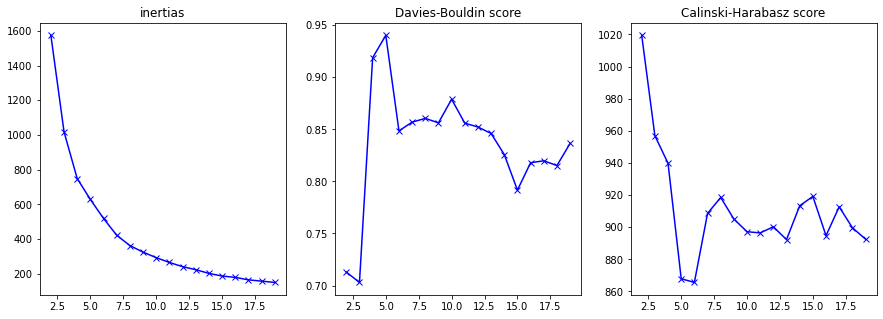

In [29]:
neurons = somxy.get_weights().reshape(gridrows*gridcols,8)
K = range(2,20)
inertias = []
DB_score = []
CH_score = []

for k in K:
    clusterSOM = KMeans(n_clusters=k, random_state=0, n_init=5, init='k-means++').fit(neurons)
    inertias.append(clusterSOM.inertia_)
    labs = clusterSOM.labels_
    DB_score.append(davies_bouldin_score(neurons, labs))
    CH_score.append(calinski_harabasz_score(neurons, labs))

fig, (ax0, ax1, ax2) = plt.subplots(1,3, figsize=(15,5))
ax0.plot(K, inertias, 'bx-')
ax0.set_title('inertias')
ax1.plot(K, DB_score, 'bx-')
ax1.set_title('Davies-Bouldin score')
ax2.plot(K, CH_score, 'bx-')
ax2.set_title('Calinski-Harabasz score')
plt.show()

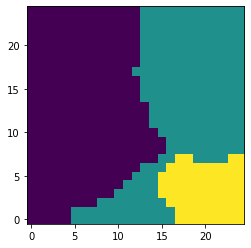

In [33]:
clusterSOM = KMeans(n_clusters=3, random_state=0, n_init=5, init='k-means++').fit(neurons)
clusters = clusterSOM.predict(neurons).reshape(gridrows,gridcols)
plt.imshow(clusters, origin='lower')
plt.show()

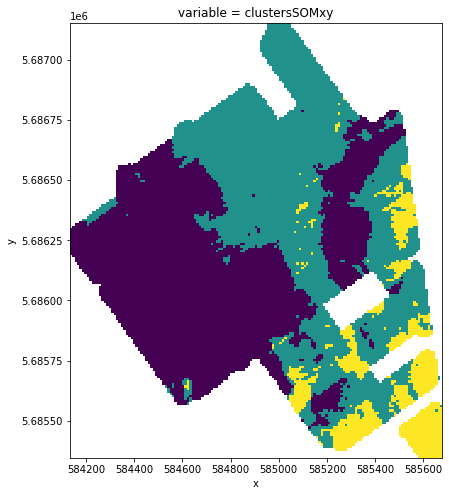

In [43]:
SOM_bmus = np.array(winners)

raster_clusters = np.empty((27540))
raster_clusters[:] = np.nan
raster_clusters[~rows_with_nan] = np.array([clusters[i] for i in winners])


df_raster['clustersSOMxy'] = raster_clusters 

xr_clusters = df_raster.to_xarray().transpose('y', 'x')

cl_array = xr_clusters.to_array()
ax = cl_array.sel(variable='clustersSOMxy').plot.pcolormesh(figsize=(8,8), add_colorbar=False)
ax.axes.set_aspect('equal')

### References

* Filippi, A., Dobreva, I., Klein, A. G., & Jensen, J. R. (2010). Self-organizing map-based applications in remote sensing. In G. K. Matsopoulos (Ed.), Self-Organizing Maps. InTech.

* Karmakar, M., Maiti, S., Singh, A., Ojha, M., & Maity, B. S. (2018). Mapping of rock types using a joint approach by combining the multivariate statistics, self-organizing map and Bayesian neural networks: An example from IODP 323 site. Marine Geophysical Research, 39(3), 407–419. https://doi.org/10.1007/s11001-017-9327-2

* Klose, C. D. (2006). Self-organizing maps for geoscientific data analysis: Geological interpretation of multidimensional geophysical data. Computational Geosciences, 10(3), 265–277. https://doi.org/10.1007/s10596-006-9022-x

* Kohonen, T. (2013). Essentials of the self-organizing map. Neural Networks, 37, 52–65. https://doi.org/10.1016/j.neunet.2012.09.018

* Riese, F. M., Keller, S., & Hinz, S. (2019). Supervised and Semi-Supervised Self-Organizing Maps for Regression and Classification Focusing on Hyperspectral Data. Remote Sensing, 12(1), 7. https://doi.org/10.3390/rs12010007

* Vettigli, G. (2018). MiniSom: Minimalistic and NumPy-based implementation of the Self Organizing Map. https://github.com/JustGlowing/minisom/